# Tutorial 1: Introduction to Deep Learning for Causal Inference on Observables
 
The following tutorials are a gentle introduction(简单介绍) to building deep learning models for causal inference using the selection on observables identification strategy（可观测物识别策略的选择）. In particular, these model are designed to estimate the  average treatment effect (ATE) and the conditional average treatment effect (CATE). The ATE is defined as:
 
$$ATE =\mathbb{E}[Y(1)-Y(0)]$$
 
where $Y(1)$ and $Y(0)$ are the potential(潜在的) outcomes had the unit received or not received the treatment, respectively. The CATE is defined as,
 
$$CATE =\mathbb{E}[Y(1)-Y(0)|X=x]$$
 
where $X$ is the set of selected, observable covariates(可观测的变量), and $x \in X$.
 
Because selection on observables is a simple identification(简单识别) strategy, these estimators are simple neural networks. This tutorial is thus also a gentle introduction to writing models in TensorFlow, and getting started coding deep learning models.
 
**These tutorials are for you if:**
 
1. You want a quick and dirty introduction to DL + Selection on Observables literature with minimal math, or...
 
2. You want a gentle introduction to writing and training custom models in Tensorflow 2 and...
 
3. You have a basic familiarity with causal inference and...
 
4. You have a basic familiarity with Python and object oriented programming.

**DISCLAIMER**: Before we get started, I want to make clear that the point of any of these pedagogical tutorials is not to argue that one of these models is empirically (or theoretically) straight-up superior to another. This is only one tiny simulation (from a [benchmark](https://arxiv.org/abs/2107.13346) that has itself been critiqued) without hyperparameter optimization. These are toy pedagogical programming examples, not benchmarking notebooks. We use the same specification and hyperparameters for all three models for comparison, but I'm sure you could get better results with each if you tweaked them. If you want to apply these to real data, you should try different things and do careful model selection.

----

## What are we doing here?

These model are designed to estimate the  average treatment effect (ATE) and the conditional average treatment effect(CATE) under a selection on observables identification strategy. The ATE is defined as:
 
$$ATE =\mathbb{E}[Y_i(1)-Y_i(0)]= \mathbb{E}[{\tau_i}]$$
 
where $Y_i(1)$ and $Y_i(0)$ are the potential outcomes had unit $i$ received or not received the treatment, respectively. The CATE is defined as,
 
$$CATE(x) =\mathbb{E}[Y_i(1)-Y_i(0)|X=x]$$

where $X$ is the set of selected, observable covariates, and $x \in X$.

Because selection on observables is a simple identification strategy, these estimators are simple neural networks. This tutorial is thus also a gentle introduction to writing models in TensorFlow, and getting started coding deep learning models.

## Why use deep learning for causal inference?

1. Appropriately built neural network models are among the **lowest bias** estimators in our statistical arsenal.

2. For similar reasons, the complex response surfaces learned by neural networks make them well-suited for estimating **heterogeneous treatment effects**.

4. Most excitingly, deep learning has the ability to allow us to control for confounding found in **complex data types like images, text, and networks**.

3. Although most of these models don't make theoretical guarantees, representation learning **might be more robust to empirical violations of overlap** than simpler adjustment strategies.

One more point: even if we cannot formally satisfy causal inference assumptions, these architectures are still very useful for **creating interpretable ML models** where we can isolate the contributions of specific covariates to predicting the outcome.

## Notation
**Causal identification**

- Observed covariates/features: $X$

- Potential outcomes: $Y(0)$ and $Y(1)$

- Treatment: $T$

- Average Treatment Effect: $ATE =\mathbb{E}[Y(1)-Y(0)]$

- Conditional Average Treatment Effect: $CATE =\mathbb{E}[Y(1)-Y(0)|X=x]$

**Deep learning estimation**

- Predicted outcomes: $\hat{Y}(0)$ and $\hat{Y}(1)$

- Outcome modeling functions: $\hat{Y}(T)=h(X,T)$

- Representation functions: $\Phi(X)$ (producing representations $\phi$)

- Loss functions: $\mathcal{L}(true,predicted)$, with the mean squared error abbreviated $MSE$ and binary cross-entropy as $BCE$

- Estimated CATE: $\hat{CATE}=(1-2t)(\hat{{y}}(t)-\hat{y}(1-t))$

- Estimated ATE: $\hat{ATE}=\frac{1}{n}\sum_{i=1}^n\hat{CATE_i}$


## Standard assumptions(假设) for causal identification under selection on observables
Standard assumptions for model-based causal inference apply here (from [Johansson et al., 2020](https://arxiv.org/pdf/2001.07426.pdf)): 
1. **Conditional Ignorability/Exchangability**.The potential outcomes $Y(0)$, $Y(1)$ and the treatment $T$ are conditionally independent given $X$,
$$Y(0),Y(1)\perp \!\!\! \perp T|X $$
Conditional gnorability specifies that there are no *unmeasured confounders* that affect both treatment and outcome outside of those in the observed covariates/features $X$.


2. **Consistency/Stable Unit Treatment Value Assumption (SUTVA)**. Consistency specifies that when a unit recieves treatment, we observe the potential outcome. Moreover, the response of any unit does not vary with the treatment assignment to other units (i.e., no network effects), and the form/level of treatment is homogeneous and consistent across units,
$$T=t \rightarrow Y=Y(T)$$


3. **Overlap** In any context $x \in X$, any treatment $t\in \{0,1\}$ has a non-zero probability of being observed in the data, 

$$\forall x \in X, t\in\{0,1\}:p(T=t|X=x)>0$$

Note that the overlap assumption does not require that the empirical data are necessarily balanced, but that the two treatment distributions have common support. 

## Data 

The IHDP dataset used in this example is a naturalistic simulation introduced in [Hill, 2011](https://www.tandfonline.com/doi/abs/10.1198/jcgs.2010.08162?casa_token=b8-rfzagECIAAAAA:QeP7C4lKN6nZ7MkDjJHFrEberXopD9M5qPBMeBqbk84mI_8qGxj01ctgt4jdZtORpu9aZvpVRe07PA) to evaluate estimation of heterogeneous treatment effects ($CATE$). The  25 covariates/features for the 747 units (139 treated（已处理过的）) in the dataset were taken from an experiment, but Hill simulated the outcomes to create known counterfactuals(已知的反事实). The data are available from Fredrik Johansson's website. IHDP is the de facto benchmark in this literature.

<details><summary>Additional details from Hill, 2011</summary>
<blockquote>[Hill] used experimental data from the Infant Health（幼儿健康） and Development Program (IHDP), a randomized experiment that began in 1985, targeted low-birth-weight, premature infants, and provided the treatment group with both intensive high-quality child care and home visits from a trained provider.... [The response surface] is nonlinear and not parallel across treatment conditions, with $Y(0)∼\mathcal{N}(exp((X+W)\beta_B),1)$ and $Y(1)∼\mathcal{N}(X\beta_B−\omega^s_B,1)$, where $W$ is an offset matrix of the same dimension as $X$ with every value equal to 0.5, $\beta_B$ is a vector of regression coefficients (0, 0.1, 0.2, 0.3, 0.4) randomly sampled with probabilities (0.6, 0.1, 0.1, 0.1,0.1). For the sth simulation, $\omega^s_B$ was chosen in the overlap（重叠） setting, where we estimate the effect of the treatment on the treated, such that theconditional average treatment effect for the treated equals 4.</blockquote>
</details>

`y` is the simulated outcome that may represent $Y(0)$ or $Y(1)$ depending on `t`. Note that we rescale it here to improve convergence（提高收敛速度）. `mu_0` and `mu_1` are "noiseless" potential outcomes(无噪声的潜在outcome) where Hill simply used the mean of the normal distribution described in the spoiler.

There are 100 stochastic simulations(随机数) in this data. For this example we will just use the eighth one.

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler 
def load_IHDP_data(training_data,testing_data,i=7):
    with open(training_data,'rb') as trf, open(testing_data,'rb') as tef:
        train_data=np.load(trf); test_data=np.load(tef)
        y=np.concatenate(   (train_data['yf'][:,i],   test_data['yf'][:,i])).astype('float32') #most GPUs only compute 32-bit floats
        t=np.concatenate(   (train_data['t'][:,i],    test_data['t'][:,i])).astype('float32')
        x=np.concatenate(   (train_data['x'][:,:,i],  test_data['x'][:,:,i]),axis=0).astype('float32')
        mu_0=np.concatenate((train_data['mu0'][:,i],  test_data['mu0'][:,i])).astype('float32')
        mu_1=np.concatenate((train_data['mu1'][:,i],  test_data['mu1'][:,i])).astype('float32')
 
        data={'x':x,'t':t,'y':y,'t':t,'mu_0':mu_0,'mu_1':mu_1}
        data['t']=data['t'].reshape(-1,1) #we're just padding one dimensional vectors with an additional dimension 
        data['y']=data['y'].reshape(-1,1)
        #rescaling y between 0 and 1 often makes training of DL regressors easier
        data['y_scaler'] = StandardScaler().fit(data['y'])
        data['ys'] = data['y_scaler'].transform(data['y'])
 
    return data
 
data =load_IHDP_data(training_data='./ihdp_npci_1-100.train.npz',testing_data='./ihdp_npci_1-100.test.npz')

#concatenate t so we can use it as input
xt = np.concatenate([data['x'], data['t']], 1)

`data` is a dictionary (equivalent to a list in R). I'll print out a bit for you to see what it looks like:

In [3]:
!pip install -q tensorflow==2.8.0

In [4]:
for key in data:
  if key == 'y_scaler': continue
  print(key, data[key][:5])

x [[-0.65613806 -1.0024741  -0.360898    0.16170253  0.24605164 -0.8577868
   1.          0.          0.          0.          1.          0.
   0.          1.          1.          1.          0.          1.
   0.          0.          0.          0.          1.          0.
   0.        ]
 [-1.7153288  -1.0024741  -0.733261    0.16170253  1.1212925   0.9639847
   1.          0.          1.          0.          0.          1.
   0.          1.          1.          1.          1.          1.
   0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.5543657   0.19681813 -0.360898   -0.879606   -0.6917064  -1.0234023
   1.          0.          0.          1.          0.          0.
   0.          2.          0.          1.          0.          1.
   0.          0.          0.          0.          0.          1.
   0.        ]
 [ 0.53274953  0.5965822  -1.4779869   0.16170253  1.0587753  -0.8577868
   1.          0.          0.          1.          0.          0.
 

## Attempt Number 1: Pure(纯) Outcome Modeling (S[ingle]-Learner)

As a means to get our feet wet, we're going to start with the simplest way to estimate $\hat{CATE}$: a single multi-layer peceptron (sometimes called feed-forward or just deep neural network).

<figure><img src=https://github.com/kochbj/Deep-Learning-for-Causal-Inference/blob/main/images/Slearner.png?raw=true width="900"><figcaption><b>Fig 1: S-learner.</b> The S-learner is a deep feed-forward network or multilayer-percepetron. In a feed-forward neural network, additional fully connected (parameterized) layers of neurons are added between the inputs and output neuron. Purple indicates inputs（紫色部分指的的是输入）, orange indicates network layers（橘色部分是网络层）, and white indicates outputs（白色是输出）. In this figure, the size of the hidden layers are first shown as nodes and then generically abstracted as boxes. The dashes between（...之间的虚线） the orange shapes indicate an unspecifed（不确定的） number of additional hidden layers. The dashed lines(虚线) on the right indicate non-gradient（非梯度） plug-in computations that occur after training（发生在训练的过程后边）. In causal inference settings, this architecture is sometimes called a S(ingle)-learner because one feed-forward network learns to predict both potential（潜在的） outcomes.</figcaption></figure>

To make this feasible（为了使其可行）, the network will take $X$ and $T$ as input and predict $Y$.

We'll label this function $h$ so $\hat{Y}=h(X,T)$.


We'll use the mean squared error as the loss,
$$\mathcal{L}(Y,h(X,T))=MSE(Y,h(X,T))=\frac{1}{n}\sum_{i=1}^n [h(x_i,t_i)-y_i]^2$$

Let's start by importing packages....

In [5]:
# !pip install -q tensorflow==2.8.0
import tensorflow as tf
import numpy as np #numpy is the numerical computing package in python
print(tf.__version__)

2.8.0


The next block specifies a function to build the model using Tensorflow 2's **Sequential API**. The **Sequential API** is the simplest of three API's in Tensorflow (see this [post](https://medium.com/tensorflow/what-are-symbolic-and-imperative-apis-in-tensorflow-2-0-dfccecb01021) for pros and cons). Most of the tutorial will be taught in the more powerful functional API, but I wanted to show you this first.

In words, this API is just taking a list of fully connected layers and creating an MLP. For now just ignore the other arguments beyond number of `units` in the layer; I'm just including all of these other specifications to make our S-learner comparable to our T-learner and TARNet.

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD

reg_l2=.01
s_learner = tf.keras.models.Sequential([
  Dense(units=200, activation='elu', kernel_initializer='RandomNormal'),
  Dense(units=200, activation='elu', kernel_initializer='RandomNormal'),
  Dense(units=200, activation='elu', kernel_initializer='RandomNormal'),
  Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2)),
  Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2)),
  Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2)),
])

2023-06-09 22:28:15.683918: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now let's specify the loss function...

In [7]:
loss_fn = tf.keras.losses.MeanSquaredError() #specify the loss

In [8]:
#@title Run this block. (Details we'll abstract away for now) { display-mode: "form" }
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD

val_split=0.2
batch_size=64
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)

sgd_callbacks = [
        TerminateOnNaN(),
        EarlyStopping(monitor='val_loss', patience=40, min_delta=0.), 
        #40 is Shi's recommendation for this dataset, but you should tune for your data 
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                          min_delta=0., cooldown=0, min_lr=0),
    ]
#optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9

Below are the two core methods we need to train our model.

`compile` creates a static computational graph of your network for training. At a minimum, you need to give it an optimizer and a loss function.

`fit` is your main training loop.

We'll pass through our data up to 300 times (may be less due to regularization conditions we'll discuss later), using batch sizes of 64. We reserve 20% of the data for validation. Ignore `sgd_callbacks` for now.

In [9]:
s_learner.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
                    loss=loss_fn,
                    metrics=loss_fn)

s_learner.fit(x=xt,y=data['ys'],
                validation_split=.2,
                epochs=300,
                batch_size=64,
                callbacks=sgd_callbacks,
                verbose=1)
print("Done")

Epoch 1/300
10/10 [==============================] - 1s 18ms/step - loss: 3.3797 - mean_squared_error: 1.0474 - val_loss: 3.6352 - val_mean_squared_error: 1.3601 - lr: 1.0000e-05
Epoch 2/300
10/10 [==============================] - 0s 4ms/step - loss: 3.3763 - mean_squared_error: 1.0804 - val_loss: 3.6299 - val_mean_squared_error: 1.3550 - lr: 1.0000e-05
Epoch 3/300
10/10 [==============================] - 0s 4ms/step - loss: 3.3720 - mean_squared_error: 1.0525 - val_loss: 3.6239 - val_mean_squared_error: 1.3492 - lr: 1.0000e-05
Epoch 4/300
10/10 [==============================] - 0s 4ms/step - loss: 3.3669 - mean_squared_error: 1.0568 - val_loss: 3.6179 - val_mean_squared_error: 1.3434 - lr: 1.0000e-05
Epoch 5/300
10/10 [==============================] - 0s 3ms/step - loss: 3.3623 - mean_squared_error: 1.0408 - val_loss: 3.6117 - val_mean_squared_error: 1.3375 - lr: 1.0000e-05
Epoch 6/300
10/10 [==============================] - 0s 4ms/step - loss: 3.3575 - mean_squared_error: 0.9837 

Epoch 47/300
10/10 [==============================] - 0s 3ms/step - loss: 3.2412 - mean_squared_error: 0.8970 - val_loss: 3.4599 - val_mean_squared_error: 1.1885 - lr: 1.0000e-05
Epoch 48/300
10/10 [==============================] - 0s 4ms/step - loss: 3.2392 - mean_squared_error: 0.8912 - val_loss: 3.4575 - val_mean_squared_error: 1.1860 - lr: 1.0000e-05
Epoch 49/300
10/10 [==============================] - 0s 4ms/step - loss: 3.2373 - mean_squared_error: 0.8782 - val_loss: 3.4550 - val_mean_squared_error: 1.1836 - lr: 1.0000e-05
Epoch 50/300
10/10 [==============================] - 0s 4ms/step - loss: 3.2354 - mean_squared_error: 0.8827 - val_loss: 3.4526 - val_mean_squared_error: 1.1812 - lr: 1.0000e-05
Epoch 51/300
10/10 [==============================] - 0s 3ms/step - loss: 3.2335 - mean_squared_error: 0.8844 - val_loss: 3.4503 - val_mean_squared_error: 1.1789 - lr: 1.0000e-05
Epoch 52/300
10/10 [==============================] - 0s 4ms/step - loss: 3.2316 - mean_squared_error: 0.

Epoch 93/300
10/10 [==============================] - 0s 3ms/step - loss: 3.1611 - mean_squared_error: 0.8222 - val_loss: 3.3631 - val_mean_squared_error: 1.0904 - lr: 1.0000e-05
Epoch 94/300
10/10 [==============================] - 0s 3ms/step - loss: 3.1595 - mean_squared_error: 0.8434 - val_loss: 3.3612 - val_mean_squared_error: 1.0885 - lr: 1.0000e-05
Epoch 95/300
10/10 [==============================] - 0s 3ms/step - loss: 3.1579 - mean_squared_error: 0.8370 - val_loss: 3.3593 - val_mean_squared_error: 1.0866 - lr: 1.0000e-05
Epoch 96/300
10/10 [==============================] - 0s 3ms/step - loss: 3.1563 - mean_squared_error: 0.8254 - val_loss: 3.3574 - val_mean_squared_error: 1.0847 - lr: 1.0000e-05
Epoch 97/300
10/10 [==============================] - 0s 4ms/step - loss: 3.1548 - mean_squared_error: 0.8100 - val_loss: 3.3556 - val_mean_squared_error: 1.0829 - lr: 1.0000e-05
Epoch 98/300
10/10 [==============================] - 0s 3ms/step - loss: 3.1532 - mean_squared_error: 0.

Epoch 184/300
10/10 [==============================] - 0s 3ms/step - loss: 3.0369 - mean_squared_error: 0.6968 - val_loss: 3.2203 - val_mean_squared_error: 0.9446 - lr: 1.0000e-05
Epoch 185/300
10/10 [==============================] - 0s 4ms/step - loss: 3.0356 - mean_squared_error: 0.7011 - val_loss: 3.2189 - val_mean_squared_error: 0.9433 - lr: 1.0000e-05
Epoch 186/300
10/10 [==============================] - 0s 3ms/step - loss: 3.0344 - mean_squared_error: 0.7366 - val_loss: 3.2176 - val_mean_squared_error: 0.9419 - lr: 1.0000e-05
Epoch 187/300
10/10 [==============================] - 0s 3ms/step - loss: 3.0332 - mean_squared_error: 0.7189 - val_loss: 3.2162 - val_mean_squared_error: 0.9405 - lr: 1.0000e-05
Epoch 188/300
10/10 [==============================] - 0s 4ms/step - loss: 3.0320 - mean_squared_error: 0.6989 - val_loss: 3.2149 - val_mean_squared_error: 0.9391 - lr: 1.0000e-05
Epoch 189/300
10/10 [==============================] - 0s 4ms/step - loss: 3.0308 - mean_squared_err

Epoch 275/300
10/10 [==============================] - 0s 3ms/step - loss: 2.9392 - mean_squared_error: 0.6176 - val_loss: 3.1122 - val_mean_squared_error: 0.8347 - lr: 1.0000e-05
Epoch 276/300
10/10 [==============================] - 0s 3ms/step - loss: 2.9382 - mean_squared_error: 0.6304 - val_loss: 3.1112 - val_mean_squared_error: 0.8337 - lr: 1.0000e-05
Epoch 277/300
10/10 [==============================] - 0s 3ms/step - loss: 2.9373 - mean_squared_error: 0.6379 - val_loss: 3.1101 - val_mean_squared_error: 0.8326 - lr: 1.0000e-05
Epoch 278/300
10/10 [==============================] - 0s 3ms/step - loss: 2.9363 - mean_squared_error: 0.6393 - val_loss: 3.1091 - val_mean_squared_error: 0.8316 - lr: 1.0000e-05
Epoch 279/300
10/10 [==============================] - 0s 3ms/step - loss: 2.9353 - mean_squared_error: 0.6223 - val_loss: 3.1080 - val_mean_squared_error: 0.8305 - lr: 1.0000e-05
Epoch 280/300
10/10 [==============================] - 0s 3ms/step - loss: 2.9344 - mean_squared_err

# Estimating the ATE/CATE

Now we can estimate causal effects in either the whole dataset or a heldout testing sample. For simplicity, we just use the whole dataset here.  This is unorthodox in machine learning, but here we are interested in inference, not prediction. 

Although our ultimate goal is to estimate the $CATE$, our loss function only minimizes the factual error to estimate $\hat{Y}$. This is a reflection of the fundamental problem of causal inference: we only observe one potential outcome for each unit. To get the quantities we want, we'll have to artificially toggle the treatment to get both $\hat{y}(t)$ and $\hat{y}(1-t)$ for each unit.


In [10]:
import pandas as pd
import numpy as np
#create fake ones and zeros to feed network
zeros=np.expand_dims(np.zeros(data['x'].shape[0]),1)
ones=np.expand_dims(np.ones(data['x'].shape[0]),1)
x_untreated = np.concatenate([data['x'], zeros], 1)
x_treated = np.concatenate([data['x'], ones], 1)
y0_pred_slearner=s_learner.predict(x_untreated)
y1_pred_slearner=s_learner.predict(x_treated)

We can then plug in our predictions $\hat{Y}(0)$ and $\hat{Y}(1)$ to calculate the predicted CATE as

$$\hat{CATE_i}=(1-2t_i)(\hat{y_i}(t)-\hat{y_i}(1-t))$$
and the predicted average treatment effect as,
$$\hat{ATE}=\frac{1}{n}\sum_{i=1}^n\hat{CATE_i}$$

Since we know the true $CATE$s in our simulations, let's go over some commonly used evaluation metrics in this literature....

# Evaluation Metrics

Within this literature, it is common practice to evaluate model performance on simulations using the Precision Estimation of Heterogeneous  Effects ($PEHE$) from [Hill, 2011](https://www.tandfonline.com/doi/abs/10.1198/jcgs.2010.08162?casa_token=b8-rfzagECIAAAAA:QeP7C4lKN6nZ7MkDjJHFrEberXopD9M5qPBMeBqbk84mI_8qGxj01ctgt4jdZtORpu9aZvpVRe07PA). $PEHE$ measures the error in estimates of the $CATE$:

$$\sqrt{PEHE}=\sqrt{\frac{1}{N}\sum_{i=1}^N(CATE_i-\hat{CATE_i})^2}$$

The PEHE is more than just a metric, it has theoretical significance in literature in the definition of generalization bounds.

Since we know both potential outcomes in simulation we might also like to calculate bias in $\hat{ATE}$ and $\hat{CATE}$,
- $ATE_{bias} = |ATE-\hat{ATE}|$
- $CATE_{bias} = \frac{1}{N}\sum_{i=1}^N |CATE_i-\hat{CATE_i}|$

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)

SQRT PEHE: 3.6402159
Estimated ATE (True is 4): 0.55002904 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(3.6402159, 3.4499709606170654)

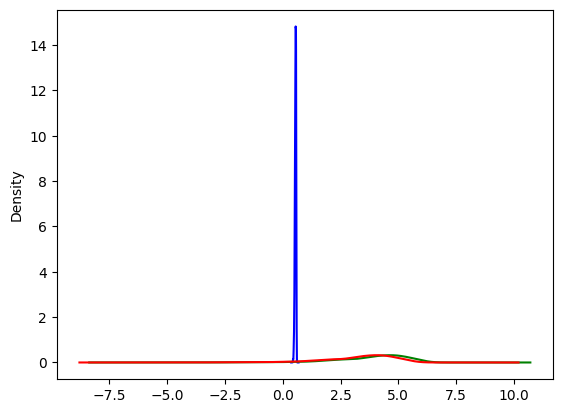

In [11]:
def plot_cates(y0_pred,y1_pred,data):
  #dont forget to rescale the outcome before estimation!
  y0_pred = data['y_scaler'].inverse_transform(y0_pred)
  y1_pred = data['y_scaler'].inverse_transform(y1_pred)
  cate_pred=(y1_pred-y0_pred).squeeze()
  cate_true=(data['mu_1']-data['mu_0']).squeeze() #Hill's noiseless true values
  ate_pred=tf.reduce_mean(cate_pred)

  print(pd.Series(cate_pred).plot.kde(color='blue'))
  print(pd.Series(cate_true).plot.kde(color='green'))

  print(pd.Series(cate_true-cate_pred).plot.kde(color='red'))
  pehe=tf.reduce_mean( tf.square( ( cate_true - cate_pred) ) )
  sqrt_pehe=tf.sqrt(pehe).numpy()
  print("\nSQRT PEHE:",sqrt_pehe)
  print("Estimated ATE (True is 4):", ate_pred.numpy(),'\n\n')
  
  print("\nError CATE Estimates: RED")
  print("Individualized CATE Estimates: BLUE")
  print("Individualized CATE True: GREEN")
  return sqrt_pehe,np.abs(ate_pred.numpy()-4)

plot_cates(y0_pred_slearner,y1_pred_slearner,data)

## Analysis of S-learner results

Before we move on, let's actually LOOK at our results. It's clear that this model ran for 300 epochs and didn't learn anything at all! Take this finding with a major grain of salt; if you played around with the optimizer, capacity (number of layers and neurons), and other settings you might get this model to converge. This would be a good exercise! But do look at the disclaimer above. Let's keep going and see if we can find something more interesting.

----


# Attempt Number 2: T-Learner

The next most sophisticated thing we could do is fit two outcomes models independently, one for $Y(0)$ and one for $Y(1)$. This network is called a T-Learner.
<figure><img src=https://github.com/kochbj/Deep-Learning-for-Causal-Inference/blob/main/images/TLearner.png?raw=true width="900"><figcaption><b>Fig 2: T-learner.</b> The T-learner consists of two independent feed-forward networks learning the two different potential outcomes. Purple indicates inputs, orange indicates network layers, and white indicates outputs. The dashes between colored shapes indicate an unspecifed number of additional hidden layers. The dashed lines on the right indicate non-gradient, plug-in computations that occur after training.</figcaption></figure>

It would be pretty easy to implement the T-Learner as we did above using two Sequential API models. Instead we are going to transition to the **Functional API.** The Functional API is keras before it was absorbed into TF2. It is much easier to write complex models with the Functional API or Imperative (OOP) API.

## Coding up T-Learner

Okay, let's build the model! The rest of this tutorial basically modifies Claudia Shi's beautiful [implementation](https://github.com/claudiashi57/dragonnet) of TARNet from her [DragonNet paper](https://arxiv.org/pdf/1906.02120.pdf) (featured in a subsequent tutorial).

It's idiomatic in the functional API to declare a layer and immediately pass it's inputs so you can follow the forward-pass through the network. The only 
layers that should be unfamiliar to you are the `Input` layer and `Concatenate` layer. Every graph is required to have an input layer to specify the dimensions of the input before compilation. `Concatenate` is just one of several utility layers in the API.

The model itself is still pretty simple: we use two output layers for each head with 100 neurons each. There are again a couple ways to have multiple outputs in the Functional API, but here we concatenate the two outputs into a list of vectors. We apply regularization to the output heads. 

In [12]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model

def make_tlearner(input_dim, reg_l2):
    '''
    The first argument is the column dimension of our data.
    It needs to be specified because the functional API creates a static computational graph
    The second argument is the strength of regularization we'll apply to the output layers
    '''
    x = Input(shape=(input_dim,), name='input')

    #in TF2/Keras it is idiomatic to instantiate a layer and pass its inputs on the same line unless the layer will be reused
    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(x)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_1')(x)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_2')(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(y1_hidden)

    #a convenience "layer" that concatenates arrays as columns in a matrix
    concat_pred = Concatenate(1)([y0_predictions, y1_predictions])
    #the declarations above have specified the computational graph of our network, now we instantiate it
    model = Model(inputs=x, outputs=concat_pred)

    return model

The `summary` method can be used to confirm that the architecture is specified correctly.

One of the advantages of the functional API is that you can also visualize static computational graphs (very similar to the cartoon representation above).

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 25)]         0           []                               
                                                                                                  
 y0_hidden_1 (Dense)            (None, 100)          2600        ['input[0][0]']                  
                                                                                                  
 y1_hidden_1 (Dense)            (None, 100)          2600        ['input[0][0]']                  
                                                                                                  
 y0_hidden_2 (Dense)            (None, 100)          10100       ['y0_hidden_1[0][0]']            
                                                                                              

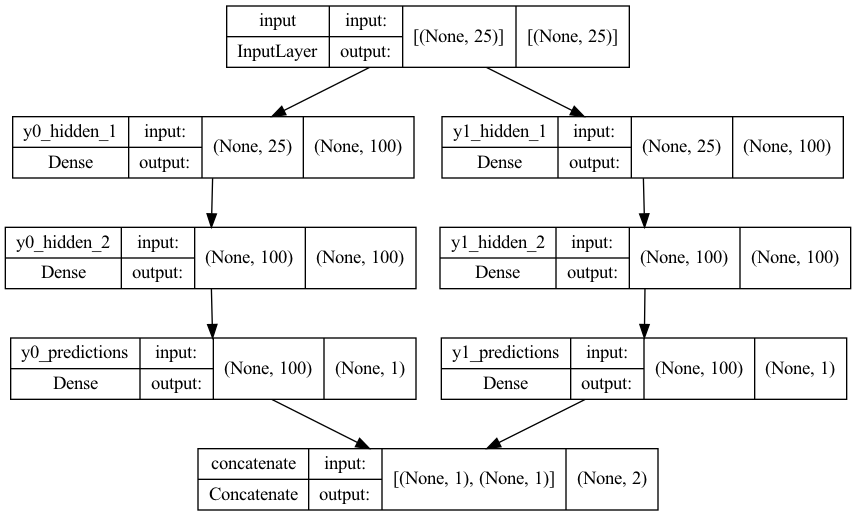

In [13]:
tlearner_model=make_tlearner(25,.01)

print(tlearner_model.summary())
tf.keras.utils.plot_model(tlearner_model, show_shapes=True, show_layer_names=True, to_file='tlearner.png')

from IPython.display import Image # this just Jupyter notebook stuff
Image(retina=True, filename='tlearner.png')


<font color='red'><h2>Check Your Understanding:</h2></font>

What will happen if we use the same loss function as above?

<details><summary>Answer</summary>

The two heads are getting the same input data so they will be calculating the same gradients and will end up learning the same thing. We have two options:

A. Feed the two networks different data. This would essentially mean training the two networks independently or restructuring our data so that batch sizes of treated and control units can be split equally after input.

B. Somehow ensure that each head only receives error gradients for the correct treatment group. This will require writing a custom loss function.

Let's go with B.
</details>



## Specifying the loss function
There are again at least four different ways to specify loss functions in Tensorflow2: if you have a standard loss there are built-in options (as above), you can specify them as custom functions, custom objects, or build them into custom layers of your network. Here we've written a function.

 Note that we compute $\mathcal{L}(Y(0),h(X,0))$ and $\mathcal{L}(Y(1),h(X,1))$ separately and just add them to get the whole loss. Tensorflow will apply the gradients appropriately to the different outcome and representation layers.

In [27]:
# every loss function in TF2 takes 2 arguments, a vector of true values and a vector predictions
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

# Training and Fitting the Model


<details><summary>A brief spoiler about training neural networks if you've never done so before.</summary>

When you use other types of machine learning models, optimization of the model parameters is typically done for you under the hood and you simply wait for training to finish. In contrast, neural networks have so many parameters that optimization becomes an art.

Rather than training on the whole training dataset at once, neural networks are trained on mini-batches of dozens to a few hundred examples. This is a compromise between applying error gradients from a single example (computationally expensive) and using the whole training dataset (expensive in terms of memory; may not work as well for losses that are not perfectly convex). The error gradient is applied to the network parameters after each mini-batch. A complete iteration through all mini-batches in the training set is called an **epoch.** 

After each epoch we run prediction on the entire validation set. While there are a number of regularization techniques used in DL to prevent overfitting (norms, dropout, batch normalization), the most important is **early stopping.** To prevent overfitting, we wish to stop training after several consecutive epochs where the validation loss has failed to improve. The number of epochs to wait after early stopping is often called a *patience* hyperparameter. 

The proportion of the gradient the optimizer backpropagates to the parameters is called the **learning rate.** A learning rate that is too small takes a long time to train. A learning rate that is too large will overshoot optima. Learning rate schedulers are used to adaptively slow the learning rate as you get closer to an optimum.

---

</details>


We will continue to use the builtin Keras `.fit` infrastructure for training the model which makes things super easy (you can of course write the training loop and calculate the gradients yourself). There are a lot of hyperparameter choices here, but I won't dwell on them because hyperparameter selection will be covered in the next tutorial.

Now let's get to the details I hid from you above!

 In this example we use stochastic gradient descent to optimize the model with an initial learning rate of 1E-4 and momentum of .9. You can also try other optimizers (e.g., ADAM). **While you should experiment with different learning rates, I recommend having a conservative (smaller) learning rate because we really want our estimator to be unbiased.**
 
 To avoid overfitting, we stop training deep learning models when the validation loss stops improving. In Tensorflow the `EarlyStopping` callback automatically stops training after a number of epochs with no improvement on the validation loss (`patience` parameter). The `ReduceLROnPlateau` adaptively lowers the learning rate of the optimizer as we approach validation loss plateaus so that the optimizer does not overshoot the current optimum.

We use a mini-batch size of 64. Other papers have recommmended batch sizes up to 200 with this dataset. **The batch size is an important consideration for these causal inference architectures because you really want to make sure each mini-batch has both treatment and control examples for the representation layers.** This is obviously less of a problem for datasets with high proportions of treated units.

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import SGD

val_split=0.2
batch_size=64
verbose=1
i = 0
tf.random.set_seed(i)
np.random.seed(i)
yt = np.concatenate([data['ys'], data['t']], 1) #we'll use both y and t to compute the loss


sgd_callbacks = [
        TerminateOnNaN(),
        EarlyStopping(monitor='val_loss', patience=40, min_delta=0.), 
        #40 is Shi's recommendation for this dataset, but you should tune for your data 
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=verbose, mode='auto',
                          min_delta=0., cooldown=0, min_lr=0),
    ]
#optimzier hyperparameters
sgd_lr = 1e-5
momentum = 0.9
tlearner_model.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
                    loss=regression_loss,
                    metrics=regression_loss)

tlearner_model.fit(x=data['x'],y=yt,
                callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size,
                verbose=verbose)
print("DONE!")

Epoch 1/300
10/10 [==============================] - 1s 19ms/step - loss: 74.7954 - regression_loss: 68.4104 - val_loss: 55.2791 - val_regression_loss: 46.9192 - lr: 1.0000e-05
Epoch 2/300
10/10 [==============================] - 0s 3ms/step - loss: 35.9019 - regression_loss: 32.0618 - val_loss: 41.7468 - val_regression_loss: 35.2642 - lr: 1.0000e-05
Epoch 3/300
10/10 [==============================] - 0s 3ms/step - loss: 27.4808 - regression_loss: 23.7049 - val_loss: 31.9059 - val_regression_loss: 26.4541 - lr: 1.0000e-05
Epoch 4/300
10/10 [==============================] - 0s 4ms/step - loss: 23.5098 - regression_loss: 19.7850 - val_loss: 29.0031 - val_regression_loss: 23.7596 - lr: 1.0000e-05
Epoch 5/300
10/10 [==============================] - 0s 4ms/step - loss: 22.6045 - regression_loss: 18.7837 - val_loss: 27.3725 - val_regression_loss: 22.3228 - lr: 1.0000e-05
Epoch 6/300
10/10 [==============================] - 0s 4ms/step - loss: 21.5720 - regression_loss: 17.8021 - val_loss:

10/10 [==============================] - 0s 3ms/step - loss: 15.4119 - regression_loss: 12.0845 - val_loss: 21.1346 - val_regression_loss: 16.4987 - lr: 1.0000e-05
Epoch 48/300
10/10 [==============================] - 0s 3ms/step - loss: 15.4421 - regression_loss: 12.0638 - val_loss: 21.0319 - val_regression_loss: 16.4027 - lr: 1.0000e-05
Epoch 49/300
10/10 [==============================] - 0s 3ms/step - loss: 15.5389 - regression_loss: 12.0096 - val_loss: 20.9560 - val_regression_loss: 16.3438 - lr: 1.0000e-05
Epoch 50/300
10/10 [==============================] - 0s 3ms/step - loss: 15.5247 - regression_loss: 12.0041 - val_loss: 20.9334 - val_regression_loss: 16.3185 - lr: 1.0000e-05
Epoch 51/300
10/10 [==============================] - 0s 3ms/step - loss: 15.5541 - regression_loss: 11.9836 - val_loss: 20.9086 - val_regression_loss: 16.3033 - lr: 1.0000e-05
Epoch 52/300
10/10 [==============================] - 0s 3ms/step - loss: 15.2732 - regression_loss: 11.9166 - val_loss: 20.8189

10/10 [==============================] - 0s 3ms/step - loss: 14.2634 - regression_loss: 10.9985 - val_loss: 19.3410 - val_regression_loss: 14.9708 - lr: 5.0000e-06
Epoch 93/300
10/10 [==============================] - 0s 3ms/step - loss: 14.3115 - regression_loss: 10.9789 - val_loss: 19.3425 - val_regression_loss: 14.9750 - lr: 5.0000e-06
Epoch 94/300
10/10 [==============================] - 0s 3ms/step - loss: 14.3128 - regression_loss: 10.9816 - val_loss: 19.3390 - val_regression_loss: 14.9708 - lr: 5.0000e-06
Epoch 95/300
 1/10 [==>...........................] - ETA: 0s - loss: 16.3854 - regression_loss: 13.5373
Epoch 95: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
10/10 [==============================] - 0s 3ms/step - loss: 14.3623 - regression_loss: 10.9628 - val_loss: 19.3189 - val_regression_loss: 14.9550 - lr: 5.0000e-06
Epoch 96/300
10/10 [==============================] - 0s 3ms/step - loss: 14.2429 - regression_loss: 10.9454 - val_loss: 19.2944 - val_r

Epoch 132/300
10/10 [==============================] - 0s 3ms/step - loss: 14.2862 - regression_loss: 10.8701 - val_loss: 19.1871 - val_regression_loss: 14.8417 - lr: 3.9062e-08
Epoch 133/300
10/10 [==============================] - 0s 3ms/step - loss: 14.1873 - regression_loss: 10.8701 - val_loss: 19.1870 - val_regression_loss: 14.8416 - lr: 3.9062e-08
Epoch 134/300
10/10 [==============================] - 0s 3ms/step - loss: 14.1224 - regression_loss: 10.8700 - val_loss: 19.1870 - val_regression_loss: 14.8416 - lr: 3.9062e-08
Epoch 135/300
10/10 [==============================] - 0s 3ms/step - loss: 14.2743 - regression_loss: 10.8699 - val_loss: 19.1869 - val_regression_loss: 14.8416 - lr: 3.9062e-08
Epoch 136/300
 1/10 [==>...........................] - ETA: 0s - loss: 13.5420 - regression_loss: 10.6941
Epoch 136: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-08.
10/10 [==============================] - 0s 3ms/step - loss: 14.1403 - regression_loss: 10.8697 - val_l

10/10 [==============================] - 0s 3ms/step - loss: 14.1079 - regression_loss: 10.8690 - val_loss: 19.1857 - val_regression_loss: 14.8405 - lr: 6.1035e-10
Epoch 173/300
10/10 [==============================] - 0s 3ms/step - loss: 14.1312 - regression_loss: 10.8690 - val_loss: 19.1857 - val_regression_loss: 14.8405 - lr: 6.1035e-10
Epoch 174/300
 1/10 [==>...........................] - ETA: 0s - loss: 13.4818 - regression_loss: 10.6339
Epoch 174: ReduceLROnPlateau reducing learning rate to 3.051757735406113e-10.
10/10 [==============================] - 0s 3ms/step - loss: 14.2200 - regression_loss: 10.8690 - val_loss: 19.1857 - val_regression_loss: 14.8405 - lr: 6.1035e-10
Epoch 175/300
10/10 [==============================] - 0s 3ms/step - loss: 14.2606 - regression_loss: 10.8690 - val_loss: 19.1857 - val_regression_loss: 14.8405 - lr: 3.0518e-10
Epoch 176/300
10/10 [==============================] - 0s 3ms/step - loss: 14.2728 - regression_loss: 10.8690 - val_loss: 19.1857 - 

10/10 [==============================] - 0s 3ms/step - loss: 14.3156 - regression_loss: 10.8690 - val_loss: 19.1857 - val_regression_loss: 14.8405 - lr: 2.3842e-12
Epoch 211/300
10/10 [==============================] - 0s 3ms/step - loss: 14.2818 - regression_loss: 10.8690 - val_loss: 19.1857 - val_regression_loss: 14.8405 - lr: 2.3842e-12
DONE!


Great! Let's calculate our causal effects and see what we get...

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)

SQRT PEHE: 0.95289177
Estimated ATE (True is 4): 3.5433586 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(0.95289177, 0.45664143562316895)

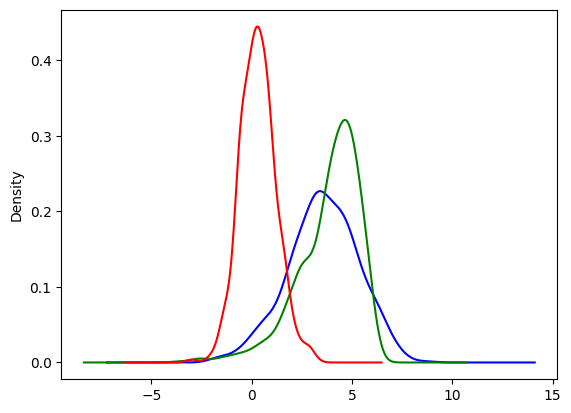

In [29]:
concat_pred=tlearner_model.predict(data['x'])
#dont forget to rescale the outcome before estimation!
y0_pred_tlearner,y1_pred_tlearner = concat_pred[:, 0],concat_pred[:, 1]
plot_cates(y0_pred_tlearner,y1_pred_tlearner,data)

# Analyzing the T-learner results

This model actually converged! The $ATE_{pred}$ is around 3.54 and $\sqrt{PEHE}$ should be around .95 We can see that the estimated $CATE$ distribution has some bias towards lower treatment effects.

----

# Attempt 3: Representation learning as a balancing strategy (TARNet)

## Representation learning

A core concept in deep learning is the idea that artificial neural networks have the capacity to project a set of complex features $X$ into a useful vector space. When data are transformed into this space, we call the resulting tensor a **representation** ([Goodfellow, et al. 2016](https://www.deeplearningbook.org/contents/representation.html)) (you might also see the term "embedding"). For social scientists most comfortable with linear models, we can think about the parameters in each feed-forward layer of a deep neural network as capturing every possible interaction between the values produced by the previous layer. Tasking the network to minimize error on a relevant downstream task encourages it to adjust these interaction parameters to learn useful representations. We can also think about these representation layers as automatically extracting useful  latent covariates/features.

The key intuition in this literature is that we want to train neural networks to learn a representation function $\Phi(X)$ where the data are deconfounded/balanced in the representation space. In other words, the distributions of the representations $\Phi(X|T=0)$ and $\Phi(X|T=1)$ are similar.

<figure><img src=https://github.com/kochbj/Deep-Learning-for-Causal-Inference/blob/main/images/balancing.png?raw=true width="900"><figcaption><a href=https://github.com/maxwshen/iap-cidl>From Shen and Johansson talk 2018</a></figcaption></figure>

Note that $\Phi$ must, in theory, be an invertible function for the  ignorability and overlap assumptions to hold. By invertible we mean that there is an inverse function such that $\Phi^{-1}(\Phi(X))=X$.
 

# TARNet
To encourage balanced representations, [Shalit et al., 2017](http://proceedings.mlr.press/v70/shalit17a/shalit17a.pdf) propose a simple two-headed neural network called Treatment Agnostic Regression Network (TARNet). Each head models a separate outcome. One head learns the function $\hat{Y}(1)=h(\Phi(X),1)$, and the other head learns the function $\hat{Y}(0)=h(\Phi(X),0)$. Both heads backpropagate their gradients to shared representation layers that learn $\Phi(X)$. Again, the hope is that these representation layers will learn to balance the data because they are used to predict both outcomes.

<figure><img src=https://github.com/kochbj/Deep-Learning-for-Causal-Inference/blob/main/images/TARNet.png?raw=true width="900"><figcaption><b>Fig 3: TARNet.</b> This architecture, originally introduced in <a href=http://proceedings.mlr.press/v70/shalit17a/shalit17a.pdf>Shalit et al., 2017</a>, is a T-learner with shared representation layers. Purple indicates inputs, orange indicates network layers, other colors indicate output layers, and white indicates outputs. The dashes between colored shapes indicate an unspecifed number of additional hidden layers. The dashed lines on the right indicate non-gradient, plug-in computations that occur after training.</figcaption></figure>


Other than this architectural change, this has the same loss as the T-Learner:

$$\mathcal{L}(Y,h(\Phi(X),T))=MSE(Y,h(\Phi(X),T))=\frac{1}{n}\sum_{i=1}^n [h(\Phi(x_i),t_i)-y_i(t_i)]^2$$

 The complete objective for the network is to minimize the parameters of $h$ and $\Phi$ for all $n$ units in the training sample such that,

\begin{equation}
\min_{h,\Phi}\frac{1}{n}\sum_{i=1}^n \mathcal{L}(y_i(t_i),h(\Phi(x_i),t_i)) + \lambda \mathcal{R}(h)\end{equation}

where $\mathcal{R}(h)$ is a model complexity term (e.g., for $L_2$ regularization) and $\lambda$ is a hyperparameter chosen by the user.


## Coding up TARNet

Okay, let's build the model!


<font color='red'><h2>Check Your Understanding:</h2></font>

How can you modify the T-Learner to make it TARNet?

If you want to see the answer you can double click on the hidden TARNet block below. **Note that even if you don't want to look at the code, you need to run this block to proceed!**

You can put your attempt in the empty code block below:

In [30]:
#@title <font color='red'>Answer:</font> Full TARNet model (Definitely read this in detail and run it!) { display-mode: "form" }
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras import Model

def make_tarnet(input_dim, reg_l2):
    '''
    The first argument is the column dimension of our data.
    It needs to be specified because the functional API creates a static computational graph
    The second argument is the strength of regularization we'll apply to the output layers
    '''
    x = Input(shape=(input_dim,), name='input')

    # REPRESENTATION
    #in TF2/Keras it is idiomatic to instantiate a layer and pass its inputs on the same line unless the layer will be reused
    #Note that we apply no regularization to the representation layers 
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_1')(x)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_2')(phi)
    phi = Dense(units=200, activation='elu', kernel_initializer='RandomNormal',name='phi_3')(phi)

    # HYPOTHESIS
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_1')(phi)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_1')(phi)

    # second layer
    y0_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y0_hidden_2')(y0_hidden)
    y1_hidden = Dense(units=100, activation='elu', kernel_regularizer=regularizers.l2(reg_l2),name='y1_hidden_2')(y1_hidden)

    # third
    y0_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y0_predictions')(y0_hidden)
    y1_predictions = Dense(units=1, activation=None, kernel_regularizer=regularizers.l2(reg_l2), name='y1_predictions')(y1_hidden)

    #a convenience "layer" that concatenates arrays as columns in a matrix
    concat_pred = Concatenate(1)([y0_predictions, y1_predictions])
    #the declarations above have specified the computational graph of our network, now we instantiate it
    model = Model(inputs=x, outputs=concat_pred)

    return model


Cool! Let's check out what the model looks like...

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 25)]         0           []                               
                                                                                                  
 phi_1 (Dense)                  (None, 200)          5200        ['input[0][0]']                  
                                                                                                  
 phi_2 (Dense)                  (None, 200)          40200       ['phi_1[0][0]']                  
                                                                                                  
 phi_3 (Dense)                  (None, 200)          40200       ['phi_2[0][0]']                  
                                                                                            

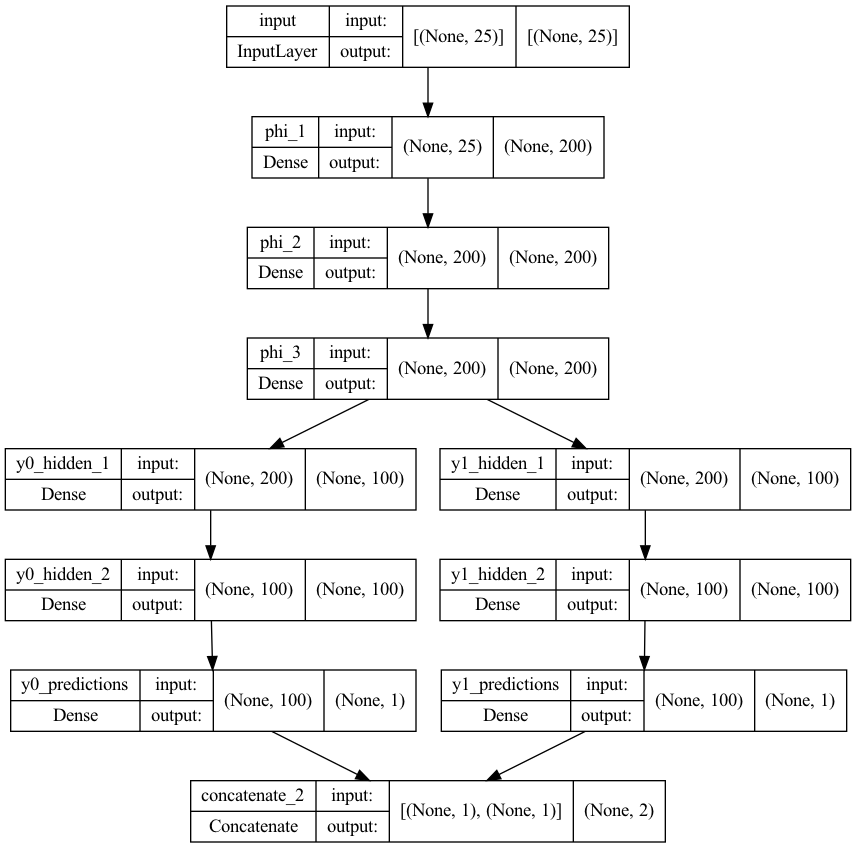

In [31]:
tarnet_model=make_tarnet(25,.01)

print(tarnet_model.summary())
tf.keras.utils.plot_model(tarnet_model, show_shapes=True, show_layer_names=True, to_file='tarnet.png')

from IPython.display import Image # this just Jupyter notebook stuff
Image(retina=True, filename='tarnet.png')

### Aside: Imperative/Object Oriented Implementation

If you prefer OOP or would like to see what this model might look like in Pytorch you can check out the spoiler below...

<details><summary>Imperative API Implementation</summary>

 The same model above might look something like this in the imperative API:
```python
class TarNet(tf.keras.Model):
    def __init__(self,
                 input_dim,
                 name='tarnet',
                 regularization=.01,
                 **kwargs):
        super(TarNet, self).__init__(name=name, **kwargs)
        self.encoder1=Dense(units=200, activation='elu', kernel_initializer='RandomNormal')
        self.encoder2=Dense(units=200, activation='elu', kernel_initializer='RandomNormal')
        self.encoder3=Dense(units=200, activation='elu', kernel_initializer='RandomNormal')

        self.regressor1_y0 = Dense(units=100, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(regularization))
        self.regressor2_y0 = Dense(units=100, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(regularization))
        self.regressorO_y0 = Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(regularization))

        self.regressor1_y1 = Dense(units=100, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(regularization))
        self.regressor2_y1 = Dense(units=100, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(regularization))
        self.regressorO_y1 = Dense(units=1, activation=None, kernel_regularizer=tf.keras.regularizers.l2(regularization))


    def call(self,inputs):
        x=self.encoder1(inputs)
        x=self.encoder2(x)
        phi=self.encoder3(x)

        out_y0=self.regressor1_y0(phi)
        out_y0=self.regressor2_y0(out_y0)
        y0=self.regressorO_y0(out_y0)

        out_y1=self.regressor1_y1(phi)
        out_y1=self.regressor2_y1(out_y1)
        y1=self.regressorO_y1(out_y1)

        concat=tf.concat([y0,y1,propensity],axis=1)
        return concat
```
</details>

# Training and Fitting the Model

Last time, we used a built-in MSE loss function, but this time we'll write it from scratch as a function. This is good practice for future tutorials.

In [32]:
# every loss function in TF2 takes 2 arguments, a vector of true values and a vector predictions
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = tf.reduce_sum((1. - t_true) * tf.square(y_true - y0_pred))
    loss1 = tf.reduce_sum(t_true * tf.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

Now we'll compile and train the model as we did for the T-learner.

In [33]:
tarnet_model.compile(optimizer=SGD(learning_rate=sgd_lr, momentum=momentum, nesterov=True),
                    loss=regression_loss,
                    metrics=regression_loss)

tarnet_model.fit(x=data['x'],y=yt,
                callbacks=sgd_callbacks,
                validation_split=val_split,
                epochs=300,
                batch_size=batch_size,
                verbose=verbose)
print("DONE!")

Epoch 1/300
10/10 [==============================] - 1s 25ms/step - loss: 64.3383 - regression_loss: 57.0393 - val_loss: 65.0698 - val_regression_loss: 53.5066 - lr: 1.0000e-05
Epoch 2/300
10/10 [==============================] - 0s 5ms/step - loss: 52.5571 - regression_loss: 46.5575 - val_loss: 55.3245 - val_regression_loss: 45.1040 - lr: 1.0000e-05
Epoch 3/300
10/10 [==============================] - 0s 5ms/step - loss: 43.9835 - regression_loss: 37.8346 - val_loss: 46.9077 - val_regression_loss: 37.7818 - lr: 1.0000e-05
Epoch 4/300
10/10 [==============================] - 0s 5ms/step - loss: 36.6830 - regression_loss: 30.8659 - val_loss: 41.1221 - val_regression_loss: 32.6989 - lr: 1.0000e-05
Epoch 5/300
10/10 [==============================] - 0s 5ms/step - loss: 32.7063 - regression_loss: 26.5906 - val_loss: 36.8626 - val_regression_loss: 28.9019 - lr: 1.0000e-05
Epoch 6/300
10/10 [==============================] - 0s 4ms/step - loss: 29.5399 - regression_loss: 23.5268 - val_loss:

10/10 [==============================] - 0s 4ms/step - loss: 17.0183 - regression_loss: 11.8184 - val_loss: 21.5174 - val_regression_loss: 15.1641 - lr: 1.0000e-05
Epoch 48/300
10/10 [==============================] - 0s 4ms/step - loss: 17.0395 - regression_loss: 11.8004 - val_loss: 21.4438 - val_regression_loss: 15.0907 - lr: 1.0000e-05
Epoch 49/300
10/10 [==============================] - 0s 4ms/step - loss: 17.1019 - regression_loss: 11.7445 - val_loss: 21.3458 - val_regression_loss: 15.0101 - lr: 1.0000e-05
Epoch 50/300
10/10 [==============================] - 0s 4ms/step - loss: 17.1504 - regression_loss: 11.7569 - val_loss: 21.3198 - val_regression_loss: 14.9850 - lr: 1.0000e-05
Epoch 51/300
10/10 [==============================] - 0s 4ms/step - loss: 17.1208 - regression_loss: 11.7415 - val_loss: 21.2912 - val_regression_loss: 14.9636 - lr: 1.0000e-05
Epoch 52/300
10/10 [==============================] - 0s 4ms/step - loss: 16.8182 - regression_loss: 11.6516 - val_loss: 21.2021

10/10 [==============================] - 0s 5ms/step - loss: 15.8343 - regression_loss: 10.7327 - val_loss: 19.5761 - val_regression_loss: 13.4764 - lr: 5.0000e-06
Epoch 93/300
10/10 [==============================] - 0s 4ms/step - loss: 15.8750 - regression_loss: 10.7037 - val_loss: 19.5744 - val_regression_loss: 13.4771 - lr: 5.0000e-06
Epoch 94/300
10/10 [==============================] - 0s 4ms/step - loss: 15.8531 - regression_loss: 10.7106 - val_loss: 19.5687 - val_regression_loss: 13.4707 - lr: 5.0000e-06
Epoch 95/300
10/10 [==============================] - 0s 4ms/step - loss: 15.9529 - regression_loss: 10.6929 - val_loss: 19.5572 - val_regression_loss: 13.4620 - lr: 5.0000e-06
Epoch 96/300
10/10 [==============================] - 0s 4ms/step - loss: 15.8005 - regression_loss: 10.6886 - val_loss: 19.5066 - val_regression_loss: 13.4131 - lr: 5.0000e-06
Epoch 97/300
10/10 [==============================] - 0s 4ms/step - loss: 15.9271 - regression_loss: 10.6980 - val_loss: 19.5157

10/10 [==============================] - 0s 4ms/step - loss: 15.6506 - regression_loss: 10.5196 - val_loss: 19.2445 - val_regression_loss: 13.1875 - lr: 1.5625e-07
Epoch 134/300
10/10 [==============================] - 0s 5ms/step - loss: 15.5944 - regression_loss: 10.5194 - val_loss: 19.2448 - val_regression_loss: 13.1877 - lr: 1.5625e-07
Epoch 135/300
10/10 [==============================] - 0s 4ms/step - loss: 15.7359 - regression_loss: 10.5192 - val_loss: 19.2447 - val_regression_loss: 13.1879 - lr: 1.5625e-07
Epoch 136/300
 1/10 [==>...........................] - ETA: 0s - loss: 14.5705 - regression_loss: 9.8776
Epoch 136: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-08.
10/10 [==============================] - 0s 4ms/step - loss: 15.6628 - regression_loss: 10.5183 - val_loss: 19.2441 - val_regression_loss: 13.1873 - lr: 1.5625e-07
Epoch 137/300
10/10 [==============================] - 0s 4ms/step - loss: 15.7144 - regression_loss: 10.5181 - val_loss: 19.2435 - va

10/10 [==============================] - 0s 4ms/step - loss: 15.6264 - regression_loss: 10.5161 - val_loss: 19.2406 - val_regression_loss: 13.1842 - lr: 1.2207e-09
Epoch 173/300
10/10 [==============================] - 0s 4ms/step - loss: 15.6553 - regression_loss: 10.5161 - val_loss: 19.2406 - val_regression_loss: 13.1842 - lr: 1.2207e-09
Epoch 174/300
 1/10 [==>...........................] - ETA: 0s - loss: 15.3055 - regression_loss: 10.6126
Epoch 174: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-10.
10/10 [==============================] - 0s 4ms/step - loss: 15.6954 - regression_loss: 10.5161 - val_loss: 19.2406 - val_regression_loss: 13.1842 - lr: 1.2207e-09
Epoch 175/300
10/10 [==============================] - 0s 4ms/step - loss: 15.7442 - regression_loss: 10.5160 - val_loss: 19.2406 - val_regression_loss: 13.1842 - lr: 6.1035e-10
Epoch 176/300
10/10 [==============================] - 0s 4ms/step - loss: 15.7579 - regression_loss: 10.5160 - val_loss: 19.2406 - 

10/10 [==============================] - 0s 4ms/step - loss: 15.7572 - regression_loss: 10.5160 - val_loss: 19.2406 - val_regression_loss: 13.1842 - lr: 4.7684e-12
Epoch 211/300
10/10 [==============================] - 0s 4ms/step - loss: 15.7792 - regression_loss: 10.5160 - val_loss: 19.2406 - val_regression_loss: 13.1842 - lr: 4.7684e-12
Epoch 212/300
10/10 [==============================] - 0s 4ms/step - loss: 15.6708 - regression_loss: 10.5160 - val_loss: 19.2406 - val_regression_loss: 13.1842 - lr: 4.7684e-12
Epoch 213/300
10/10 [==============================] - 0s 4ms/step - loss: 15.7696 - regression_loss: 10.5160 - val_loss: 19.2406 - val_regression_loss: 13.1842 - lr: 4.7684e-12
Epoch 214/300
 1/10 [==>...........................] - ETA: 0s - loss: 15.5497 - regression_loss: 10.8568
Epoch 214: ReduceLROnPlateau reducing learning rate to 2.384185730786026e-12.
10/10 [==============================] - 0s 4ms/step - loss: 15.6280 - regression_loss: 10.5160 - val_loss: 19.2406 - 

# Estimating the ATE/CATE

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)

SQRT PEHE: 0.6104328
Estimated ATE (True is 4): 3.6850023 



Error CATE Estimates: RED
Individualized CATE Estimates: BLUE
Individualized CATE True: GREEN


(0.6104328, 0.31499767303466797)

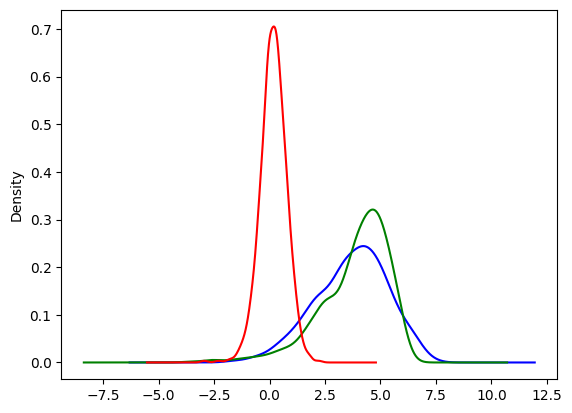

In [34]:
concat_pred=tarnet_model.predict(data['x'])
#dont forget to rescale the outcome before estimation!
y0_pred_tarnet,y1_pred_tarnet = concat_pred[:, 0],concat_pred[:, 1]
plot_cates(y0_pred_tarnet,y1_pred_tarnet,data)

## Analyzing TARNet Results
Compared to the T-learner, the distribution of predicted $CATE$s visually appears to be less biased. The $ATE$ and $\sqrt{PEHE}$ estimates are slightly more accurate as well. In the next tutorial, we'll focus on hyperparameter optimization to further zero in our models.

# Exploring Heterogeneity
 
Of course we can also break down these heterogeneous treatment effects to see if we can find any interesting patterns using, for example, Google's [Facet Dive](https://pair-code.github.io/facets/). This is just demonstrative since our covariates are meaningless in the simulation, but it's still cool. The Facet Dive is now built into TensorBoard. 

In [ ]:
#@title Explore Heterogeneity Using the Facet Dive

data['cate_pred']=y1_pred_tarnet-y0_pred_tarnet
facet_df=pd.DataFrame(data['x'])
facet_df['t']=data['t']
facet_df['y']=data['y']
facet_df['cate_pred']=data['cate_pred']


# Display the Dive visualization for the training data.
from IPython.core.display import display, HTML

jsonstr = facet_df.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

# Thats it!

- In this tutorial we wrote some simple causal estimators starting with the S-learner, moving up to the T-learner, and ending with TARNet.

- We learned how to write custom models using the sequential and functional APIs in TF2, as well as custom losses.

- We built a TARNet model and tested it on the IHDP data.

# Up next...
- In the [second tutorial](https://colab.research.google.com/drive/1y9i8koqPqs8JSyVHkdZmjGEW6ntqPV73?usp=sharing) we will dig a bit deeper into model design. We'll learn how to assess convergence using Tensorboard, and tailor TarNet models to your dataset through hyperparameter optimization using [kerastuner](https://keras-team.github.io/keras-tuner/).

- In the [third tutorial](https://colab.research.google.com/drive/19JJNyGAvSJCY8xP8vkVUXFf3-uEdDuss?usp=sharing), we'll introduce some more sophisticated elaborations of TARNet built on semiparametric theory shown in [Shi et al., 2019](https://arxiv.org/pdf/1906.02120.pdf).

- In the [fourth tutorial](https://colab.research.google.com/drive/1d8kvEXk_j268rrYq8QC_hbkfhLmp742Y?usp=sharing), we demonstrate TARNet extensions using integral probability metrics from [Shalit et al., 2017](https://arxiv.org/abs/1606.03976), [Johansson et al. 2018](https://arxiv.org/abs/1903.03448), and [Johansson et al., 2020](https://arxiv.org/abs/2001.07426).

**If you enjoyed the tutorials please email me for the paper and star the Github repository!**

**Thanks!**

### Bonus: Explore Heterogeneity Using the Facet Dive
Just for fun, we can also break down these heterogeneous treatment effects to see if we can find any interesting patterns using, for example, Google's [Facet Dive](https://pair-code.github.io/facets/). This is just demonstrative since our covariates are meaningless in the simulation, but it's still cool. The Facet Dive is now built into TensorBoard. 

In [ ]:
#@title Load Facet Dive { display-mode: "form" }
cate_pred=(y1_pred_tarnet-y0_pred_tarnet).squeeze()
data['cate_pred']=cate_pred
facet_df=pd.DataFrame(data['x'])
facet_df['t']=data['t']
facet_df['y']=data['y']
facet_df['cate_pred']=data['cate_pred']


# Display the Dive visualization for the training data.
from IPython.core.display import display, HTML

jsonstr = facet_df.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))